<a href="https://colab.research.google.com/github/msc-acse/acse-9-independent-research-project-OliverJBoom/blob/master/Chai_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linking to Github

In [0]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!rm -rf Chai_Base
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git Chai_Base

github password··········
Cloning into 'Chai_Base'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 17 (delta 3), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (17/17), done.


## Linking to Google Drive

In [0]:
from google.colab import drive
drive.mount("/content/gdrive/")
path = "/content/gdrive/My Drive/Chai/Data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


## Loading Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [0]:
cu_lme =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuLME.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_shfe =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuSHFE.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_com_s =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuCOMS.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)
cu_com_p =  pd.read_csv("/content/gdrive/My Drive/Chai/Data/CuCOMP.csv", index_col='date', parse_dates=['date'], dayfirst=True).sort_index(ascending=True)

universe_dict = {"lme":cu_lme, "shfe":cu_shfe, "com_s":cu_com_s, "com_p":cu_com_p}

## Preprocessing

In [439]:
def price_rename(universe_dict):
  """Renaming the column of the dataframe values to price"""
  for df_name in universe_dict:
    df = universe_dict[df_name]
    df.sort_index(inplace=True)
    df = df.rename(columns={'value':"price"})
    universe_dict[df_name] = df
  return universe_dict


def clean_data(df, n_std = 20):
  """Removes any outliers that are further than a chosen
  number of standard deviations from the mean"""
  upper = df.price.mean() + n_std * (df.price.std())
  lower = df.price.mean() - n_std * (df.price.std())
  df.loc[((df.price > upper) | (df.price < lower)), 'price'] = None
  df.ffill(inplace=True)
  if df.price.isnull().sum() > 0: print("Rows removed:", df.price.isnull().sum())
  return df


def clean_dict_gen(universe_dict):
  """Returns a dictionary of cleaned dataframes"""
  cleaned_dict = {}
  print("Included Instrument:")
  for df_name in universe_dict:
    print(df_name)
    cleaned_dict[df_name] = clean_data(universe_dict[df_name])
    
  return cleaned_dict


universe_dict = clean_dict_gen(price_rename(universe_dict))

Included Instrument:
lme
shfe
com_s
com_p


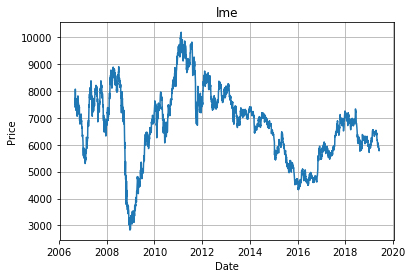

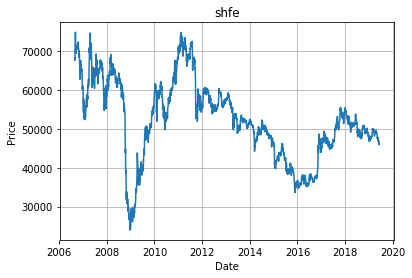

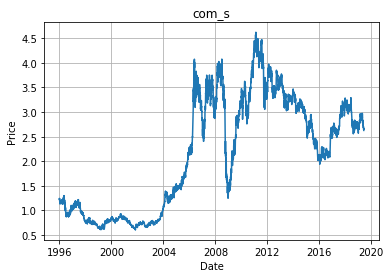

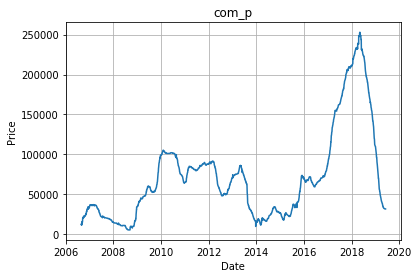

In [440]:
def visualise_plots(universe_dict, frequency="MS"):
  """Plotting the line graph for all of the 
  instruments being inspected"""
  for df_name in universe_dict:
    df = universe_dict[df_name]
    plt.plot(df.index, df.price)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(df_name)
    plt.grid()
    plt.show()
    
visualise_plots(universe_dict)
# df.info()
# plt.hist((df.price), bins=20)
# plt.show()

In [0]:
def feature_spawn(df):
  """Spawsn features for each instrument
  Returns df with the following columns
  Price
  Log Returns
  EWMA 1 day
  EWMA 1 week
  EWMA 1 month
  EWMA 1 quarter
  EWMA 6 months
  EWMA 1 year
  Rolling vol 1 week
  Rolling vol 1 month
  Rolling vol 1 quarter
  """
  df["lg_return"] = np.log(df.price) - np.log(df.price.shift(1))
  #df["deciles_lg_return"] = pd.qcut(df.lg_return, 10, labels=False)
  df.lg_return.fillna(0, inplace=True)
  
  hlf_dict = {"week":5, "month":22, "quarter":66, "half_year":130, "year":261}

  for half_life in hlf_dict:
    df["ema_" + half_life] = df.price.ewm(span=hlf_dict[half_life]).mean()
    
  for i, half_life in enumerate(hlf_dict):
    if i < 3:
      df["roll_vol_" + half_life] = df.price.rolling(window=hlf_dict[half_life]).std(ddof=0)
  
  df.dropna(inplace=True)
  return df

In [0]:
def feature_view(df):
  """Visualises the features for an instrument"""
  fig, axarr = plt.subplots(len(df.columns), 1, figsize=(10, 4 * len(df.columns)))

  for ax, df_name in zip(axarr.flatten(), df.columns):
      ax.set_title(df_name)
      ax.plot(df.index, df[df_name])
      ax.grid()
      ax.legend()
      
  plt.show()
  
# feature_view(df)

In [0]:
def consistent_training_window_length(universe_dict):
  """Chopping the length of all of the dataframes to ensure
  that they are all between the same dates
  Returns: A dictionary of the dataframes with equal lengths
  between equal dates"""
  start_date_arr = []
  end_date_arr = []
  
  for df_name in universe_dict:
    # Finding the latest of the start dates
    start_date_arr.append(universe_dict[df_name].index[0])
    # Finding the earliest of the end dates
    end_date_arr.append(universe_dict[df_name].index[-1])
    
  for i, df_name in enumerate(universe_dict): 
    # Filters the dataframe between these dates
    universe_dict[df_name] = df.loc[((df.index <= min(end_date_arr)) & (df.index >= max(start_date_arr)))]
    # Ensures that the length of each dataframe is consistent
    if i > 0: assert(len(universe_dict[list(universe_dict.keys())[0]].index) == len(universe_dict[df_name].index))
  
  return universe_dict


def feature_generator(universe_dict):
  """Spawns features for every df in the training set"""
  for df_name in universe_dict: universe_dict[df_name] = feature_spawn(universe_dict[df_name])
  return universe_dict


def training_dataset_gen(universe_dict):
  """"""
  df = universe_dict[list(universe_dict.keys())[0]]
  for i, df_name in enumerate(universe_dict): 
    if i > 0: df = pd.merge(df, universe_dict[df_name], left_index=True, right_index=True)
  return df


def column_rename(universe_dict):
  """Adding the name of the dataframe onto each column so 
  that the column can be identified post merge and pca"""
  for df_name in universe_dict: universe_dict[df_name].columns = universe_dict[df_name].columns + "_" + df_name
  return universe_dict


universe_dict = consistent_training_window_length(universe_dict)
universe_dict = feature_generator(universe_dict)
universe_dict = column_rename(universe_dict)
df_train = training_dataset_gen(universe_dict)

## PCA

In [409]:
def dimension_selector(df, thresh=0.99):
  """Returns the number of dimensions that reaches the 
  threshold level of desired variance"""
  for n_dim in range(1, 11):
    pca = PCA(n_components=n_dim)
    pca.fit(df)
    if sum(pca.explained_variance_ratio_) > thresh: 
      print("Number of dimensions:", n_dim)
      return n_dim
  print("No level of dimensionality reaches threshold variance level")
  return None

    
def dimension_reduce(df, n_dim):
  """"""
  pca = PCA(n_components=n_dim)
  pca.fit(df)
  df_reduced = pca.transform(df) 
  print("Explained Variance:", pca.explained_variance_ratio_, 
     "\nExplained Variance Sum:", sum(pca.explained_variance_ratio_))
  return df_reduced


def inverse_pca(df_reduced, df, n_dim):
  """"""
  pca = PCA(n_components=n_dim)
  pca.fit(df)
  df_inverse = pd.DataFrame(pca.inverse_transform(pca_reduced), index=df.index, columns=df.columns)
  return 
n_dim = dimension_selector(df)

Number of dimensions: 3


In [360]:
# Creating PCA object
pca = PCA(n_components=n_dim)
# Fitting and transforming PCA data
pca.fit(df)
pca_reduced = pca.transform(df) 

print("Explained Variance:", pca.explained_variance_ratio_, 
     "\nExplained Variance Sum:", sum(pca.explained_variance_ratio_))

# df_pca = pd.DataFrame(pca_reduced, index=df.index) 
# df_inverse = pd.DataFrame(pca.inverse_transform(pca_reduced), index=df.index, columns=df.columns)

Explained Variance: [0.93443161 0.05385666 0.00543059] 
Explained Variance Sum: 0.9937188687776084


In [461]:
# Creating PCA object
pca = PCA(n_components=n_dim)
# Fitting and transforming PCA data
pca.fit(df_train)
pca_reduced = pca.transform(df_train) 
print("Explained Variance:", pca.explained_variance_ratio_, 
     "\nExplained Variance Sum:", sum(pca.explained_variance_ratio_))

df_pca = pd.DataFrame(pca_reduced, index=df_train.index) 
df_inverse = pd.DataFrame(pca.inverse_transform(pca_reduced), index=df_train.index, columns=df_train.columns)

Explained Variance: [0.95582572 0.03727906 0.00359951] 
Explained Variance Sum: 0.9967042867859301


In [463]:
df_pca.head()

,0,1,2
date,,,
2009-01-02,15620.276956,1163.954442,970.301777
2009-01-05,15664.324138,1144.787741,948.052409
2009-01-06,15425.504624,875.879435,707.464978
2009-01-07,15439.288077,852.161532,684.972110
2009-01-08,15607.712664,959.963079,774.881853
